上一节主要基于PRML中10.3节的内容，利用变分推断实现了贝叶斯线性回归，并且效果还不错，但是呢，还留下了一个超参数$\beta$需要人工设定，这一节我们假设$\beta$也来源于一个Gamma分布，然后利用变分推断来求解，所以接下来的推导会和上一节有很多相同的地方，但为了完整性还是将这部分内容copy过来

### 一.联合概率分布
贝叶斯线性回归的图模型如下  
![avatar](./source/15_VI_贝叶斯线性回归图模型.png)
我们的似然函数和共轭先验可以假设如下：   

$$
p(t\mid w,\beta)=\prod_{n=1}^N N(t_n\mid w^T\phi(x_n),\beta^{-1})\\
p(w\mid \alpha)=N(w\mid 0,\alpha^{-1}I)\\
p(\alpha)=Gam(\alpha\mid a_0,b_0)\\
p(\beta)=Gam(\beta\mid a_1,b_1)
$$  
这里，$X=\{x_1,x_2,...,x_N\}$，$I$为单位矩阵，所以所有变量上的联合概率分布为：     

$$
p(t,w,\alpha,\beta)=p(t\mid w,\beta)p(w\mid\alpha)p(\alpha)p(\beta)
$$

### 二.变分分布
接下来，我们就是要构建一个变分分布$q(w,\alpha,\beta)$去近似后验概率分布$p(w,\alpha,\beta\mid t)$，利用平均场假设，令：   

$$
q(w,\alpha,\beta)=q(w)q(\alpha)q(\beta)
$$  

根据VI第一节最后推导的公式，我们可以直接写出最优解：   

$$
ln\ q^*(\alpha)=ln\ p(\alpha)+E_w[ln\ p(w\mid\alpha)]+const\\
=(a_0-1)ln\ \alpha-b_0\alpha+\frac{M}{2}ln\ \alpha-\frac{\alpha}{2}E[w^Tw]+const
$$  

可以发现这个Gamma分布取对数的形式，通过观察系数项，我们有  

$$
q^*(\alpha)=Gam(a\mid a_N,b_N)
$$  

其中  

$$
a_N=a_0+\frac{M}{2}\\
b_N=b_0+\frac{1}{2}E[w^Tw]
$$  

同样的方式，我们可以求解$q^*(w)$：   

$$
ln\ q^*(w)=E_\beta[ln\ p(t\mid w,\beta)]+E_\alpha[ln\ p(w\mid \alpha)]+const\\
=-\frac{E[\beta]}{2}\sum_{n=1}^N\left \{w^T\phi(x_n)-t_n\right \}^2-\frac{1}{2}E[\alpha]w^Tw+const\\
=-\frac{1}{2}w^T(E[\alpha]I+E[\beta]\Phi^T\Phi)w+E[\beta] w^T\Phi^Tt+const
$$  

可以发现这是关于$w$的二次型，所以$q^*(w)$是一个高斯分布，通过配方可以得到：   

$$
q^*(w)=N(w\mid m_N,S_N)
$$  

其中   

$$
m_N=E[\beta] S_N\Phi^Tt\\
S_N=(E[\alpha]I+E[\beta]\Phi^T\Phi)^{-1}
$$  

可以发现，相比于上一节，$\alpha,\beta$分别变为了$E[\alpha],E[\beta]$   

接下来就是$q^*(\beta)$：

$$
ln\ q^*(\beta)=ln\ p(\beta)+E_w[ln\ p(t\mid w,\beta)]+const\\
=(a_1-1)ln\ \beta-b_1\beta+\frac{N}{2}ln\ \beta-\frac{\beta}{2}E_w[(t-\Phi w^T)^T(t-\Phi w^T)]
$$  

显然，这也是一个Gamma分布取对数的形式，它的形式如下：   
$$
q^*(\beta)=Gam(\beta\mid a_M,b_M)
$$  
其中  

$$
a_M=a_1+\frac{N}{2}\\
b_M=b_1+\frac{1}{2}E_w[(t-\Phi w^T)^T(t-\Phi w^T)]
$$

### 三.迭代求解

同样地，$q^*(w),q^*(\alpha),q^*(\beta)$之间互相耦合，$q^*(w)$中需要用到$E[\alpha],E[\beta]$，$q^*(\alpha)$中需要用到$E[w^Tw]$，而$q^*(\beta)$需要用到$E_w[(t-\Phi w^T)^T(t-\Phi w^T)]$，根据Gamma分布和高斯分布的性质，我们可以写出这几个期望的求解公式   

$$
E[\alpha]=\frac{a_N}{b_N}\\
E[\beta]=\frac{a_M}{b_M}\\
E[w^Tw]=m_N^Tm_N+Tr(S_N)\\
E_w[(t-\Phi w^T)^T(t-\Phi w^T)]=E_w[w^T\Phi^T\Phi w]-2E_w[w^T\Phi^Tt]+t^Tt\\
=m_N^T\Phi^T\Phi m_N+Tr(\Phi S_N\Phi^T)-2m_N^T\Phi^Tt+t^Tt
$$  

那么，我们初始随意为$E[\alpha],E[\beta]$赋予一个大于0的值，就可以迭代起来了：$E_0[\alpha]\rightarrow E_0[\beta]\rightarrow E_0[w^Tw]\rightarrow E_0[(t-\Phi w^T)^T(t-\Phi w^T)] \rightarrow  \cdots$

### 四.预测分布

该过程与上一节一样   

$$
p(\hat{t}\mid \hat{x},t)=\int p(\hat{t}\mid\hat{x},w)p(w\mid t)dw\\
\simeq \int p(\hat{t}\mid\hat{x},w)q(w)dw\\
=\int N(\hat{t}\mid w^T\phi(\hat{x}),\beta^{-1})N(w\mid m_N,S_N)dw\\
=N(\hat{t}\mid m_N^T\phi(\hat{x}),\sigma^2(\hat{x}))
$$  

这里$\sigma^2(\hat{x})=\frac{1}{\beta}+\phi(\hat{x})^TS_N\phi(\hat{x})$

### 五.代码实现

In [1]:
"""
代码同样封装到ml_models.vi中，上一vi版本的类名改为LinearRegression1
"""
import numpy as np
import matplotlib.pyplot as plt


class LinearRegression(object):
    def __init__(self, basis_func=None, tol=1e-5, epochs=100):
        """
        :param basis_func: list,基函数列表，包括rbf,sigmoid,poly_{num},linear，fm,默认None为linear，其中poly_{num}中的{num}表示多项式的最高阶数,fm表示构建交叉因子
        :param tol:  两次迭代参数平均绝对值变化小于tol则停止
        :param epochs: 默认迭代次数
        """
        if basis_func is None:
            self.basis_func = ['linear']
        else:
            self.basis_func = basis_func
        self.tol = tol
        self.epochs = epochs
        # 特征均值、标准差
        self.feature_mean = None
        self.feature_std = None
        # 训练参数，也就是m_N
        self.w = None

    def _map_basis(self, X):
        """
        将X进行基函数映射
        :param X:
        :return:
        """
        n_sample, n_feature = X.shape
        x_list = []
        for basis_func in self.basis_func:
            if basis_func == "linear":
                x_list.append(X)
            elif basis_func == "rbf":
                x_list.append(np.exp(-0.5 * X * X))
            elif basis_func == "sigmoid":
                x_list.append(1 / (1 + np.exp(-1 * X)))
            elif basis_func.startswith("poly"):
                p = int(basis_func.split("_")[1])
                for pow in range(1, p + 1):
                    x_list.append(np.power(X, pow))
            elif basis_func == 'fm':
                X_fm = np.zeros(shape=(n_sample, int(n_feature * (n_feature - 1) / 2)))
                c = 0
                for i in range(0, n_feature - 1):
                    for j in range(i + 1, n_feature):
                        X_fm[:, c] = X[:, i] * X[:, j]
                        c += 1
                x_list.append(X_fm)
        return np.concatenate(x_list, axis=1)

    def fit(self, X, y):
        self.feature_mean = np.mean(X, axis=0)
        self.feature_std = np.std(X, axis=0) + 1e-8
        X_ = (X - self.feature_mean) / self.feature_std
        X_ = self._map_basis(X_)
        X_ = np.c_[np.ones(X_.shape[0]), X_]
        n_sample, n_feature = X_.shape

        E_alpha = 1.0
        E_beta = 1.0
        current_w = None
        for _ in range(0, self.epochs):
            S_N = np.linalg.inv(E_alpha * np.eye(n_feature) + E_beta * X_.T @ X_)
            self.w = E_beta * S_N @ X_.T @ y.reshape((-1, 1))  # 即m_N
            if current_w is not None and np.mean(np.abs(current_w - self.w)) < self.tol:
                break
            current_w = self.w
            # 更新 E_alph,E_beta
            E_w = (self.w.T @ self.w)[0][0] + np.trace(S_N)
            E_alpha = (n_feature - 1) / E_w  # 这里假设a_0,b_0都为0
            E_w_phi = np.dot(y.reshape(-1), y.reshape(-1)) + np.sum(X_ @ S_N * X_) + (self.w.T @ X_.T @ X_ @ self.w)[0][
                0] - 2 * (self.w.T @ X_.T @ y.reshape((-1, 1)))[0][0]
            E_beta = (n_sample - 1) / E_w_phi  # 这里假设a_1,b_1都为0
            
        # ml_models.vi包中，没有这一部分
        return E_alpha, E_beta

    def predict(self, X):
        X_ = (X - self.feature_mean) / self.feature_std
        X_ = self._map_basis(X_)
        X_ = np.c_[np.ones(X_.shape[0]), X_]
        return (self.w.T @ X_.T).reshape(-1)

    def plot_fit_boundary(self, x, y):
        """
        绘制拟合结果
        :param x:
        :param y:
        :return:
        """
        plt.scatter(x[:, 0], y)
        plt.plot(x[:, 0], self.predict(x), 'r')

### 六.测试

In [2]:
#造伪样本
X=np.linspace(0,100,100)
X=np.c_[X,np.ones(100)]
w=np.asarray([3,2])
Y=X.dot(w)
X=X.astype('float')
Y=Y.astype('float')
X[:,0]+=np.random.normal(size=(X[:,0].shape))*3#添加噪声
Y=Y.reshape(100,1)

In [3]:
#加噪声
X=np.concatenate([X,np.asanyarray([[100,1],[101,1],[102,1],[103,1],[104,1]])])
Y=np.concatenate([Y,np.asanyarray([[3000],[3300],[3600],[3800],[3900]])])

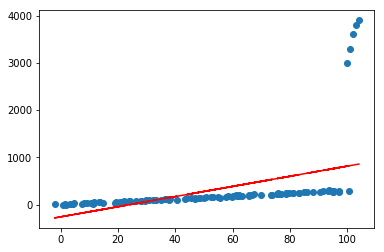

In [4]:
%matplotlib inline
lr=LinearRegression()
alpha,beta=lr.fit(X[:,:-1],Y)
lr.plot_fit_boundary(X[:,:-1],Y)

In [5]:
alpha/beta

2.0081038570209815

可以发现L2正则化项的约束还没有证据近似的结果紧...，有些忧伤....，该问题留到后面再优化...